# <center>Visual search with k-NN</center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.metrics import confusion_matrix
%matplotlib inline
sns.set()

We will load data from data.npz file.

In [2]:
# Load all numpy arrays except training images (in order to save memory).
def load_data():
    with np.load('data.npz', allow_pickle=True) as npz_file:
        #X_train = npz_file['X_train']
        X_valid = npz_file['X_valid']
        X_test = npz_file['X_test']
        X_train_features = npz_file['X_train_features']
        X_valid_features = npz_file['X_valid_features']
        X_test_features = npz_file['X_test_features']
        y_train_1h = npz_file['y_train_1h']
        y_valid_1h = npz_file['y_valid_1h']
        y_test_1h = npz_file['y_test_1h']
        y_train = npz_file['y_train']
        y_valid = npz_file['y_valid']
        y_test = npz_file['y_test']
        class_indices = npz_file['class_indices']
        train_filenames = npz_file['train_filenames']
        valid_filenames = npz_file['valid_filenames']
        test_filenames = npz_file['test_filenames']
    return X_train_features, y_train_1h, y_train, train_filenames, X_valid,X_valid_features, y_valid_1h, y_valid, valid_filenames, X_test, X_test_features, y_test_1h, y_test, test_filenames,class_indices

# load training images
def load_images():
    with np.load('data.npz', allow_pickle=True) as npz_file:
        X_train = npz_file['X_train']
    return X_train

# merge two dictionaries.
def merge_dict(x,y):
    d = x.copy()
    d.update(y)
    return d

# show list of images
def show_images(images, lines = 1, cols=1, figsize=(30,10),titles=None):
    n = images.shape[0]
    fig = plt.figure(figsize=figsize)
    for i in range(n):
        a = fig.add_subplot(lines, cols, i + 1)
        image = images[i].reshape((images.shape[1],images.shape[2],images.shape[3]))
        plt.imshow(image)
        if type(titles)==type(None):
            titles_=list(range(n))
        else:
            titles_=titles
        a.set_title(f'{titles_[i]}')
        a.axis('off')
    fig.set_size_inches(figsize)
    plt.show()
    
X_train_features, y_train_1h, y_train, train_filenames, X_valid,X_valid_features, y_valid_1h, y_valid, valid_filenames, X_test, X_test_features, y_test_1h, y_test, test_filenames,class_indices = load_data()


## Visual search with k-NN
The idea here is to implement a little search engine based on the high-level image representation and k-nearest neighbors.
- Fit and tune a k-NN classi􀁿er


In [3]:
def fit_model(model, grid, X_tr, y_tr, X_va, y_va, X_t, y_t):
    valid_scores = []
    train_scores = []
    params = []
    for params_dict in grid:
        # print (params_dict)
        params.append(params_dict)
        model.set_params(**params_dict)
        model.fit(X_tr, y_tr)
        train_scores.append(model.score(X_tr, y_tr))
        valid_scores.append(model.score(X_va, y_va))
    best_index = np.argmax(valid_scores)
    # refit model with best params
    model.set_params(**params[best_index])
    model.fit(X_tr, y_tr)
    test_score = model.score(X_t, y_t)
    return { 'best_params':params[best_index],
              'params':params,
             'train_scores':train_scores,
             'valid_scores':valid_scores,
             'test_score':test_score,
             'best_index':best_index,
              'best_valid_score':valid_scores[best_index],
              'best_model':model
            }


We will fit KNN model with a grid of hyperparameters.
The used score for KNN is accuracy.

In [4]:
grid = ParameterGrid(
    {
        'knn__n_neighbors': np.arange(1,10),
        'knn__p': [1, 2] # L1, L2 distances#
    }
)

pipe = Pipeline([
('scaler', StandardScaler()),
('knn', KNeighborsClassifier())
])

fit_knn = fit_model(pipe, grid, X_train_features, y_train, X_valid_features, y_valid, X_test_features, y_test)

{'knn__n_neighbors': 1, 'knn__p': 1}
{'knn__n_neighbors': 1, 'knn__p': 2}
{'knn__n_neighbors': 2, 'knn__p': 1}
{'knn__n_neighbors': 2, 'knn__p': 2}
{'knn__n_neighbors': 3, 'knn__p': 1}
{'knn__n_neighbors': 3, 'knn__p': 2}
{'knn__n_neighbors': 4, 'knn__p': 1}
{'knn__n_neighbors': 4, 'knn__p': 2}
{'knn__n_neighbors': 5, 'knn__p': 1}
{'knn__n_neighbors': 5, 'knn__p': 2}
{'knn__n_neighbors': 6, 'knn__p': 1}
{'knn__n_neighbors': 6, 'knn__p': 2}
{'knn__n_neighbors': 7, 'knn__p': 1}
{'knn__n_neighbors': 7, 'knn__p': 2}
{'knn__n_neighbors': 8, 'knn__p': 1}
{'knn__n_neighbors': 8, 'knn__p': 2}
{'knn__n_neighbors': 9, 'knn__p': 1}
{'knn__n_neighbors': 9, 'knn__p': 2}


Best params, best validation score, and test accuracy score are :

In [5]:
print('Best params : ', fit_knn['best_params'])
print('Best validation score : ', fit_knn['best_valid_score'])
print('Test score : ', fit_knn['test_score'])

Best params :  {'knn__n_neighbors': 5, 'knn__p': 1}
Best validation score :  0.9280575539568345
Test score :  0.94


The charts bellow presents the train and validation accuracy score for each parameter n_neighbours value.

There is a chart for each combinaison of weights (uniform, distance) and distance (L1, L2).

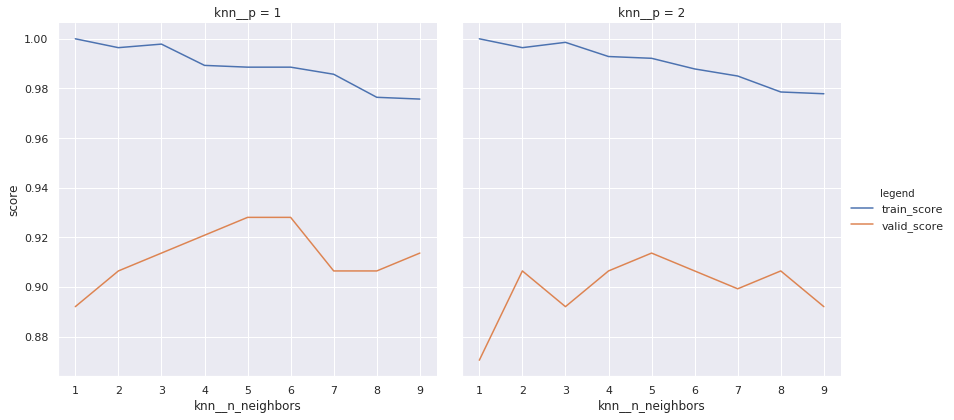

In [6]:
knn = pd.DataFrame([ merge_dict(x, {'valid_score':fit_knn['valid_scores'][i],'train_score':fit_knn['train_scores'][i]}) for i, x in enumerate(fit_knn['params']) ])
data=pd.melt(knn, id_vars=['knn__n_neighbors','knn__p'], value_vars=['train_score','valid_score'], var_name='legend', value_name='score')
g = sns.FacetGrid(data, col="knn__p",hue="legend",height=6)
g = g.map(sns.lineplot, "knn__n_neighbors", "score")
g.add_legend();

Validation accuracy score increases until 5 n_neighbours and begin to decrease.
L1 distance gives best results than L2.

- Pick an image from the test set and plot its 10 nearest neighbors from the train set

The confusion matrix of our classifier is :

In [7]:
cm = pd.DataFrame(
confusion_matrix(y_true=y_test, y_pred=fit_knn['best_model'].predict(X_test_features)),
columns=['pred: '+x for x in class_indices],
index=['true: '+x for x in class_indices],
)
cm

,pred: bike,pred: car,pred: motorcycle,pred: other,pred: truck,pred: van
true: bike,12,0,0,0,0,0
true: car,0,11,0,0,0,0
true: motorcycle,0,0,9,0,0,0
true: other,0,0,0,5,1,0
true: truck,0,0,0,0,6,1
true: van,0,0,0,0,1,4


We will choose a test image which was classified correctlly.

In [8]:
test_image_id = [0]

The following code will find the 10 nearest neighbours of the test image.

The first array is distances, and second array is image indexes in the input array.

In [10]:
X_test_image = fit_knn['best_model'].named_steps['scaler'].transform(X_test_features[test_image_id])
n_10 = fit_knn['best_model'].named_steps['knn'].kneighbors(X_test_image,10)
n_10

(array([[ 934.03196672, 1044.68619955, 1088.0945175 , 1091.91532715,
         1097.79490823, 1101.90564259, 1118.18551152, 1127.57850794,
         1131.91442911, 1136.76551308]]),
 array([[ 682,  212, 1287,  376, 1166,  789,  930,  664,  168,  558]]))

The test image is the following :

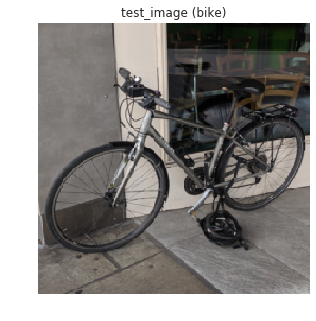

In [11]:
show_images(X_test[test_image_id],1,1,(5,5),['test_image ('+class_indices[y_test[i]]+')' for i in test_image_id])

The 10 nearest neghbours of test image in training set are :

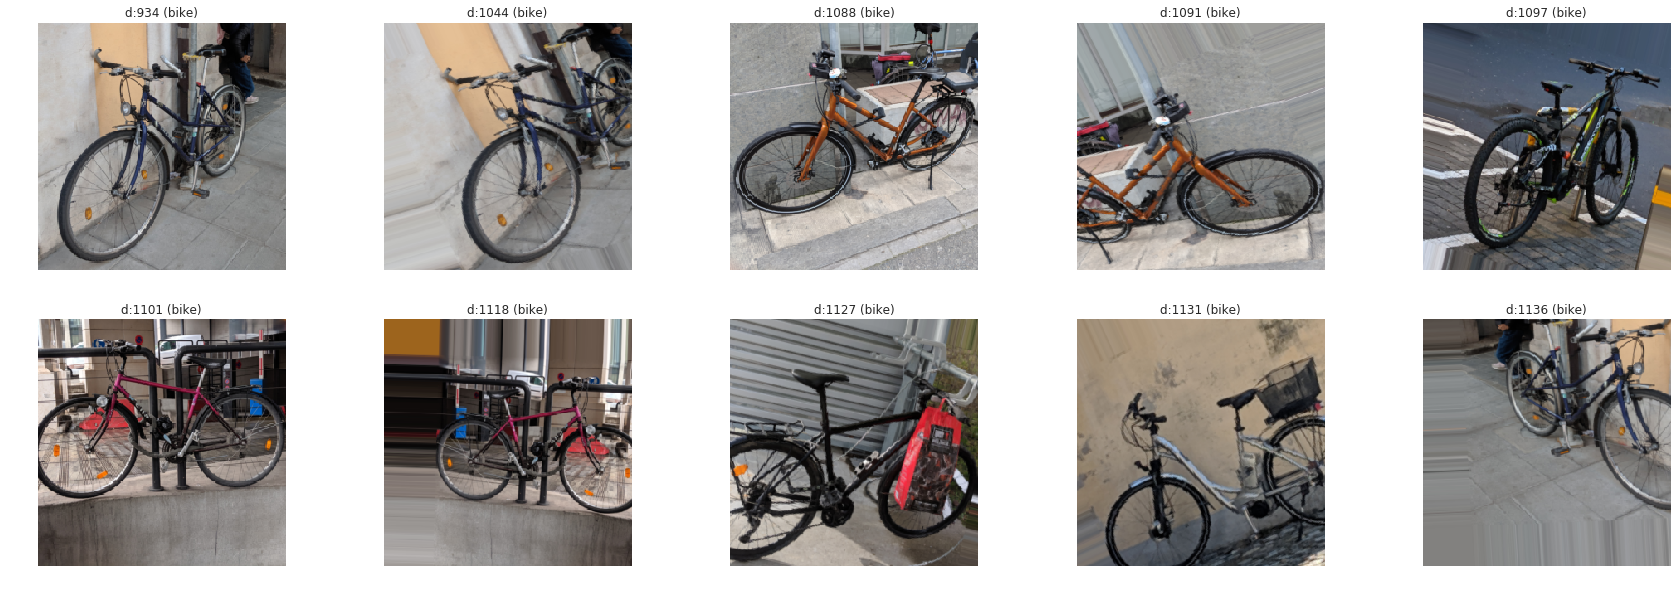

In [12]:
X_train = load_images()
show_images(X_train[n_10[1][0]],2,5,(30,10),['d:'+str(int(x))+' ('+class_indices[y_train[i]]+')' for x,i in zip(n_10[0][0],n_10[1][0])])

Lets take another image where prediction has failed :

In [13]:
np.argwhere(y_test!=fit_knn['best_model'].predict(X_test_features))

array([[33],
       [42],
       [48]])

In [14]:
test_image_id = [48]

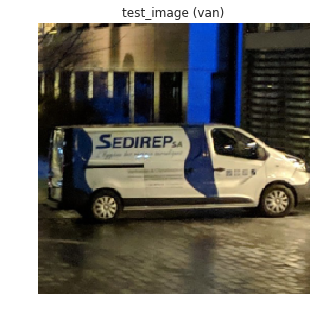

In [15]:
X_test_image = fit_knn['best_model'].named_steps['scaler'].transform(X_test_features[test_image_id])
n_10 = fit_knn['best_model'].named_steps['knn'].kneighbors(X_test_image,10)
show_images(X_test[test_image_id],1,1,(5,5),['test_image ('+class_indices[y_test[i]]+')' for i in test_image_id])

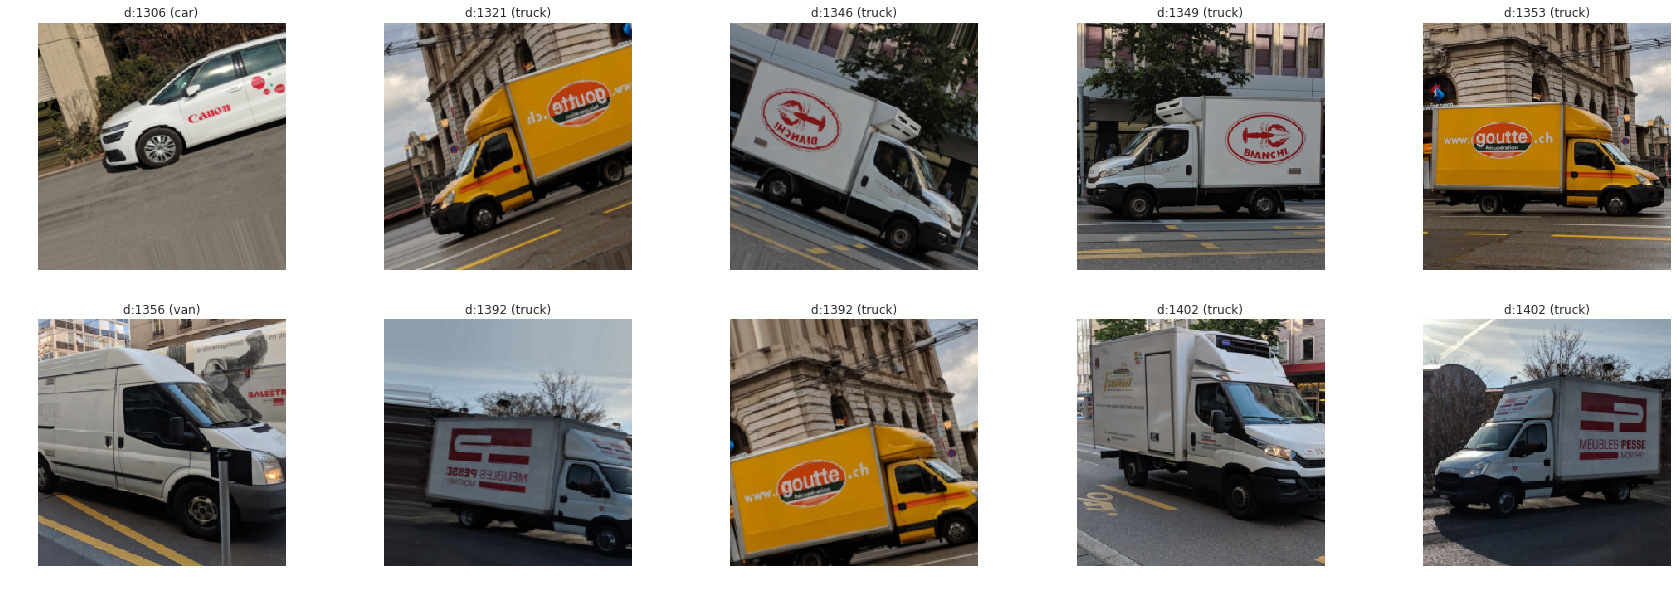

In [16]:
show_images(X_train[n_10[1][0]],2,5,(30,10),['d:'+str(int(x))+' ('+class_indices[y_train[i]]+')' for x,i in zip(n_10[0][0],n_10[1][0])])

Van and trucks here looks similar. In the PCA two component chart, the van and truck data points are not clearly separate.

In [17]:
del X_train